In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud
from ast import literal_eval

In [2]:
from pymongo import MongoClient
client = MongoClient()
client.list_database_names()
star_wars = client['star_wars']
star_wars.list_collection_names()
cursor = star_wars['movies'].find({})
dialogues = pd.DataFrame(list(cursor))
dialogues = dialogues.replace('None', np.nan).dropna()

In [3]:
dialogues.head()

,_id,index,character,dialogue
1,615ed9c029153af68be0d128,1,THREEPIO,Did you hear that? They've shut down the main...
2,615ed9c029153af68be0d129,2,THREEPIO,We're doomed!
3,615ed9c029153af68be0d12a,3,THREEPIO,There'll be no escape for the Princess this time.
4,615ed9c029153af68be0d12b,4,THREEPIO,What's that?
5,615ed9c029153af68be0d12c,5,THREEPIO,I should have known better than to trust the l...


In [4]:
dialogues['character'].value_counts()

LUKE                494
HAN                 459
THREEPIO            301
LEIA                227
VADER               140
                   ... 
PORKINS               1
DEAK                  1
NAVIGATOR             1
WOMAN                 1
WOMAN CONTROLLER      1
Name: character, Length: 129, dtype: int64

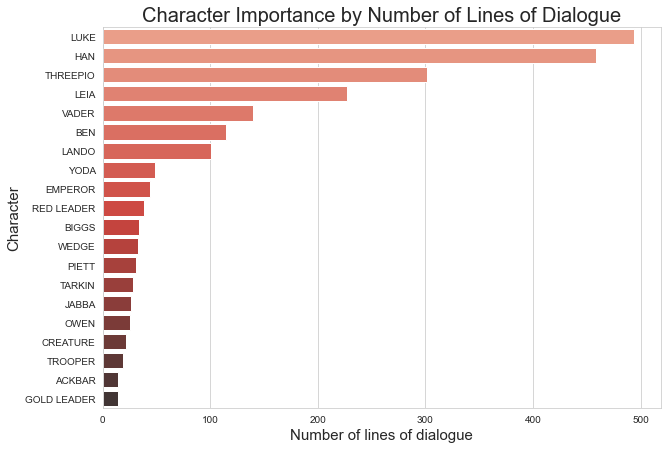

In [5]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.countplot(y='character', data=dialogues, order=dialogues.character.value_counts().iloc[:20].index, palette="Reds_d")
plt.xlabel('Number of lines of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Lines of Dialogue', fontsize=20)
plt.show()

In [6]:
dialogues['dialogue_wordcount'] = dialogues['dialogue'].map(lambda x:len(re.findall(r'\w+', x)))

In [7]:
dialogues

,_id,index,character,dialogue,dialogue_wordcount
1,615ed9c029153af68be0d128,1,THREEPIO,Did you hear that? They've shut down the main...,20
2,615ed9c029153af68be0d129,2,THREEPIO,We're doomed!,3
3,615ed9c029153af68be0d12a,3,THREEPIO,There'll be no escape for the Princess this time.,10
4,615ed9c029153af68be0d12b,4,THREEPIO,What's that?,3
5,615ed9c029153af68be0d12c,5,THREEPIO,I should have known better than to trust the l...,17
...,...,...,...,...,...
2521,615ed9c029153af68be0db00,670,LANDO,"Wedge, I don't think we're going to make it.",11
2522,615ed9c029153af68be0db01,671,WEDGE,You'll make it. Just follow me Gold Leader.,9
2523,615ed9c029153af68be0db02,672,LANDO,I promised to return his ship without a scratc...,17
2524,615ed9c029153af68be0db03,673,HAN,Lando...,1


In [8]:
total_char_words = dialogues.groupby('character', as_index=False).dialogue_wordcount.sum()
total_char_words = pd.DataFrame(total_char_words)
total_char_words

,character,dialogue_wordcount
0,ACKBAR,215
1,ANAKIN,21
2,ANNOUNCER,17
3,ASSISTANT OFFICER,11
4,ASTRO-OFFICER,18
...,...,...
124,WOMAN,8
125,WOMAN CONTROLLER,5
126,Y-WING PILOT,3
127,YODA,822


Text(0.5, 1.0, 'Character Importance by Number of Words of Dialogue')

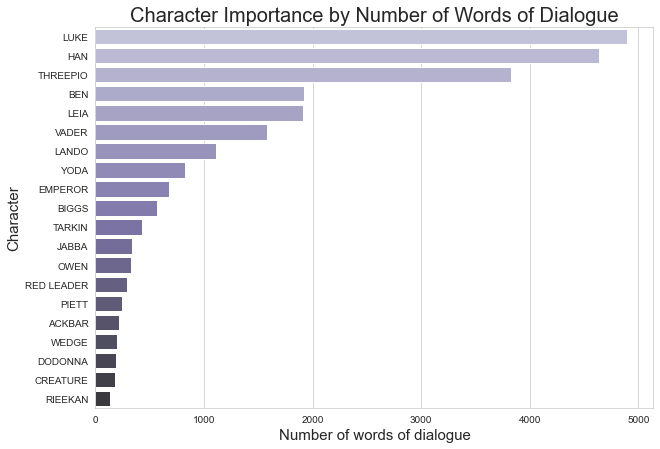

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x='dialogue_wordcount',y='character', data=total_char_words, palette="Purples_d", order=total_char_words.sort_values('dialogue_wordcount', ascending=False).character[0:20], orient='h')
plt.xlabel('Number of words of dialogue', fontsize=15)
plt.ylabel('Character', fontsize=15)
plt.title('Character Importance by Number of Words of Dialogue', fontsize=20)

In [10]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words = [PorterStemmer().stem(w) for w in filtered_words]
    lemma_words=[WordNetLemmatizer().lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [11]:
dialogues['cleanText']=dialogues['dialogue'].map(lambda x:preprocess(x))

Text(0.5, 1.0, 'Common words')

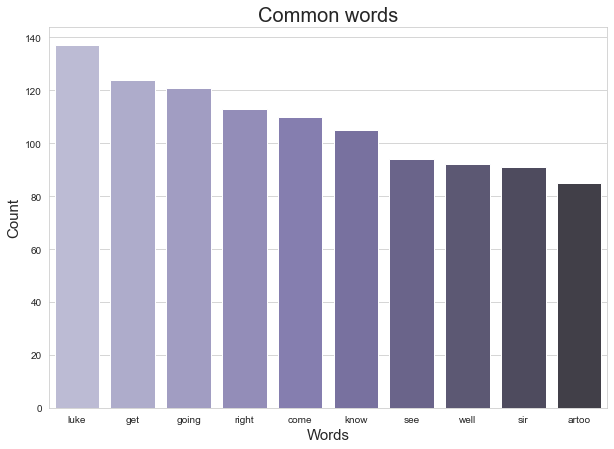

In [12]:
common_words = Counter(" ".join(dialogues["cleanText"]).split()).most_common(10)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_words], y=[x[1] for x in common_words], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Common words', fontsize=20)

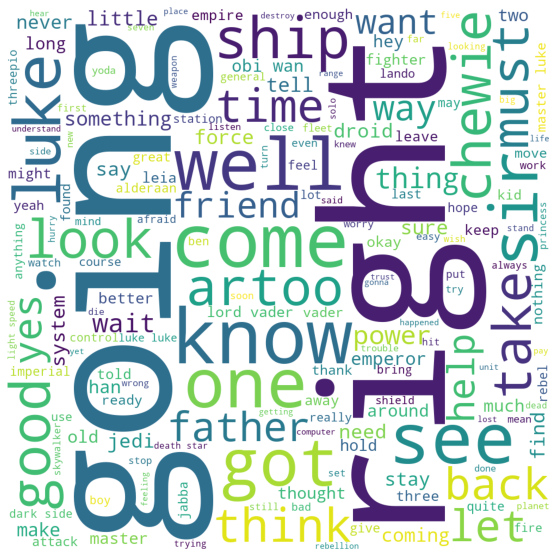

In [13]:
text = " ".join(line for line in dialogues["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [14]:
luke = dialogues[dialogues['character']=='LUKE']

Text(0.5, 1.0, 'Luke')

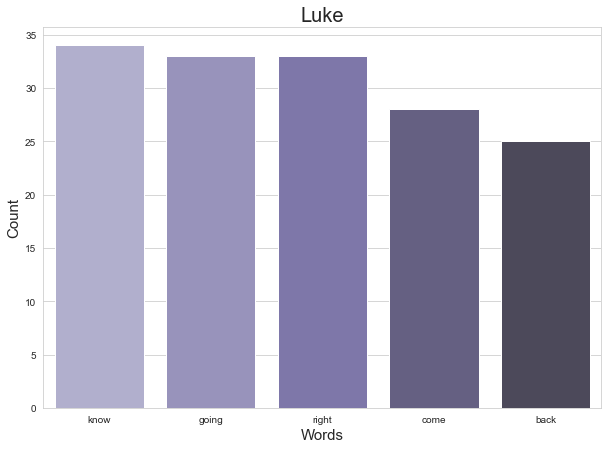

In [15]:
common_luke = Counter(" ".join(luke["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_luke], y=[x[1] for x in common_luke], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Luke', fontsize=20)

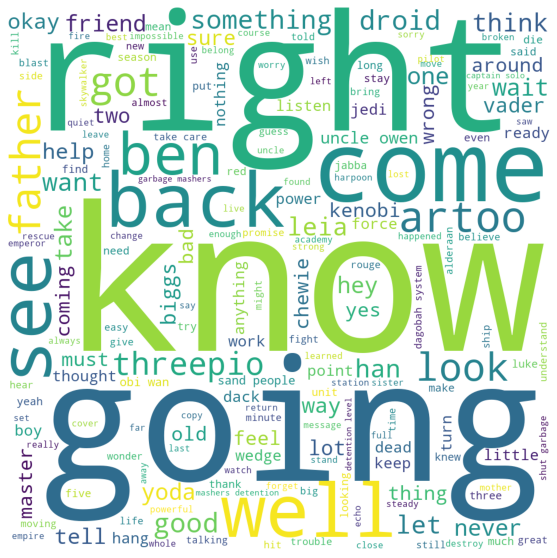

In [16]:
luke_text = " ".join(line for line in luke["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(luke_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [17]:
han = dialogues[dialogues['character']=='HAN']

Text(0.5, 1.0, 'Han')

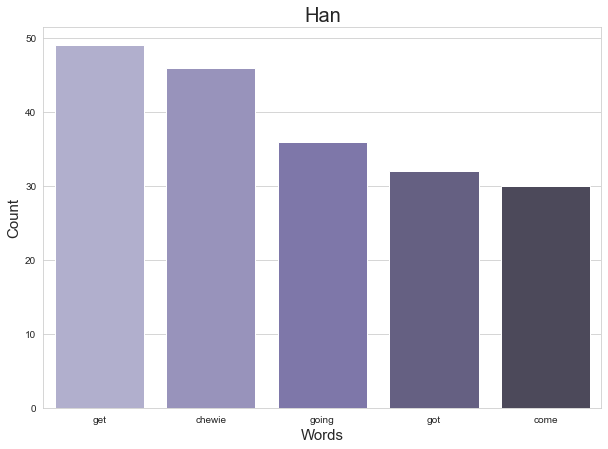

In [18]:
common_han = Counter(" ".join(han["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_han], y=[x[1] for x in common_han], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Han', fontsize=20)

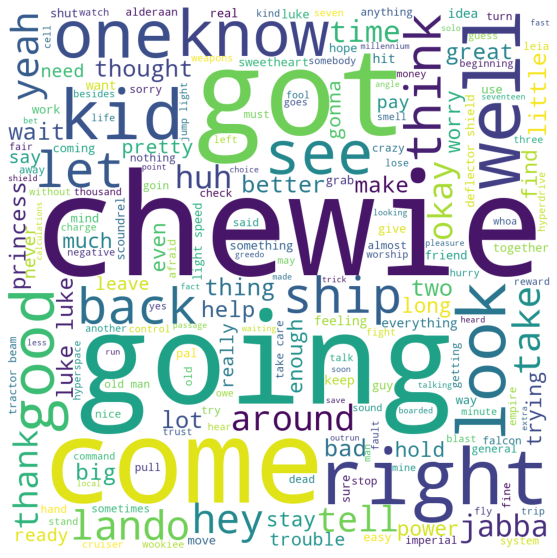

In [19]:
han_text = " ".join(line for line in han["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(han_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [20]:
pio = dialogues[dialogues['character']=='THREEPIO']

Text(0.5, 1.0, 'Luke')

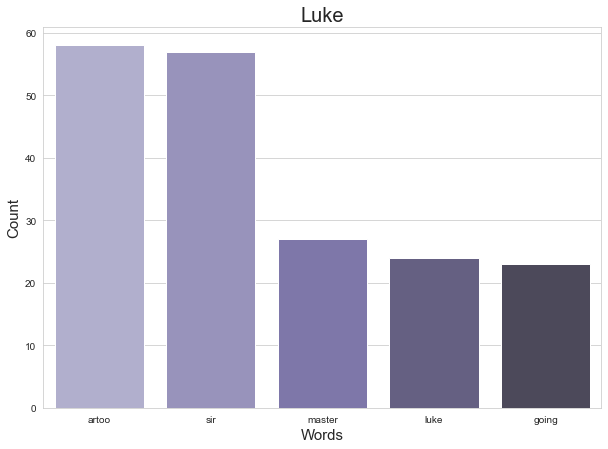

In [21]:
common_pio = Counter(" ".join(pio["cleanText"]).split()).most_common(5)
sns.set_style('whitegrid')
plt.figure(figsize=(10,7))
sns.barplot(x=[x[0] for x in common_pio], y=[x[1] for x in common_pio], palette="Purples_d")
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.title('Luke', fontsize=20)

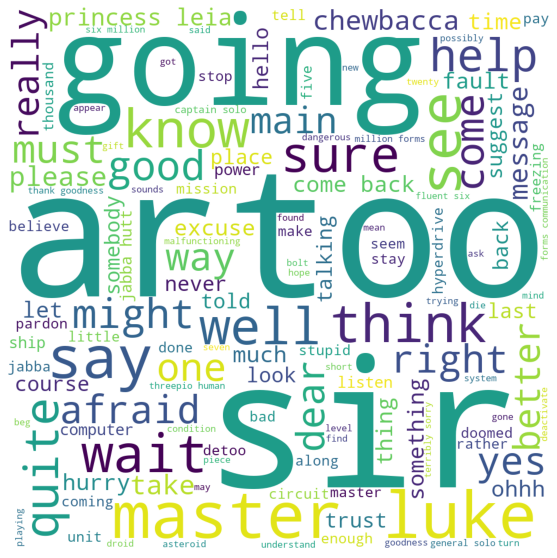

In [22]:
pio_text = " ".join(line for line in pio["cleanText"])
wordcloud = WordCloud(width=1000, height=1000, background_color="white", min_font_size=15).generate(pio_text)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()